# Analysis of System Metrics Data on IBM i Systems

Experimental notebook to explore the data from the IBM i System Metrics using Prometheus. This notebook is a work in progress.

@author: [Adam Shedivy]

In [42]:
import requests
from dataclasses import dataclass
from typing import List, Any, Dict
import pandas as pd
from collections import defaultdict

In [43]:
# Define the Prometheus query and time range
query = "SYSACT__AVERAGE_CPU_RATE"
setp = '1d' # 3 hours

# Define the Prometheus server URL
url = "http://localhost:9090/api/v1/query"

# Define the request parameters
params = {
    "query": f'{query}[{setp}]'
}

response = requests.get(url, params=params)
data = response.json()["data"]["result"]
for d in data:
    print(d)

{'metric': {'__name__': 'SYSACT__AVERAGE_CPU_RATE', 'driver_class': 'com.ibm.as400.access.AS400JDBCDriver', 'hostname': 'ut33p23', 'instance': '9.5.249.229:9853', 'job': 'prometheus'}, 'values': [[1681146910.628, '100'], [1681146970.584, '200'], [1681147030.539, '100'], [1681147090.495, '101.35'], [1681147150.45, '100'], [1681147210.407, '90'], [1681147270.362, '100'], [1681147330.318, '100'], [1681147390.273, '116.66'], [1681147450.229, '112.5'], [1681147510.184, '100'], [1681147570.14, '100'], [1681147630.096, '100'], [1681147690.051, '100'], [1681147750.007, '80'], [1681147809.997, '125'], [1681147869.967, '100'], [1681147929.923, '87.5'], [1681147989.879, '133.33'], [1681148049.835, '100'], [1681148109.79, '100'], [1681148169.746, '150'], [1681148229.702, '100'], [1681148289.658, '100'], [1681148349.614, '100'], [1681148409.569, '150'], [1681148469.527, '150'], [1681148529.481, '88.88'], [1681148589.437, '85.71'], [1681148649.394, '100'], [1681148709.349, '100'], [1681148769.306, '

## `PrometheusQuery` Class

The `PrometheusQuery` class is used to interact with a Prometheus server via its API.

### Methods

- `__init__(self, url: str = "http://localhost:9090/api/v1/query") -> None`: Constructor method that initializes the `PrometheusQuery` object with a URL to a Prometheus server. The default URL is `http://localhost:9090/api/v1/query`.

- `_get_data(self, query: str, step: str) -> List[dict]`: Private method that sends a GET request to the Prometheus server with the specified query and time step parameters, and returns a list of dictionaries containing the query results.

- `get_data(self, query: str=None, step: str=None, params: Dict[str, str] = None) -> List[dict]`: Public method that sends a GET request to the Prometheus server with optional query, time step, and additional parameter inputs, and returns a list of dictionaries containing the query results.

- `create_metrics(self, query: str, step: str) -> List["PrometheusMetric"]`: Public method that creates a list of `PrometheusMetric` objects from the results of a query with the specified query and time step parameters.

- `dataframe(self, query, step) -> pd.DataFrame`: Public method that creates a Pandas DataFrame from the results of a query with the specified query and time step parameters. The resulting DataFrame is cleaned up by removing extra rows and columns.

- `run_query(self, query: str, step: str = "1h") -> pd.DataFrame`: Public method that is a wrapper around the `dataframe` method. It creates a Pandas DataFrame from the results of a query with the specified query and time step parameters, and returns the resulting DataFrame.

- `get_raw_metrics(self) -> Dict[str, "PrometheusMetric"]`: Public method that returns a dictionary of `PrometheusMetric` objects that are the raw output from each query.

- `get_cleaned_metrics(self) -> Dict[str, pd.DataFrame]`: Public method that returns a dictionary of cleaned-up Pandas DataFrames from each query.

## `PrometheusMetric` Class

The `PrometheusMetric` class is used to represent a single metric retrieved from a Prometheus server.

### Methods

- `__init__(self, metric: dict) -> None`: Constructor method that initializes the `PrometheusMetric` object with a dictionary containing the metric data. The metric data is expected to contain the following fields: `__name__`, `driver_class`, `hostname`, `instance`, `job`, and `values`.

- `name`: Public attribute that stores the name of the metric.

- `driver_class`: Public attribute that stores the driver class of the metric.

- `hostname`: Public attribute that stores the hostname of the metric.

- `instance`: Public attribute that stores the instance of the metric.

- `job`: Public attribute that stores the job name of the metric.

- `values`: Public attribute that stores the values of the metric.


In [44]:

class PrometheusQuery:
    def __init__(self, url: str = "http://localhost:9090/api/v1/query") -> None:
        self.url = url
        self.raw_metrics: Dict[str, "PrometheusMetric"] = defaultdict(list)
        self.cleaned_metrics : Dict[str, pd.DataFrame] = defaultdict(pd.DataFrame)

    def _get_data(self, query: str, step: str) -> List[dict]:
        params = {
            "query": f'{query}[{step}]'
        }
        response = requests.get(self.url, params=params)
        return response.json()["data"]["result"]
    
    def get_data(self, query: str=None, step: str=None, params: Dict[str, str] = None) -> List[dict]:
        response = requests.get(self.url, params=params)
        return response.json()
    
    def create_metrics(self, query: str, step: str) -> List["PrometheusMetric"]:
        return [PrometheusMetric(metric) for metric in self._get_data(query, step)]
    
    def dataframe(self, query, step) -> pd.DataFrame:
        self.metrics_ = self.create_metrics(query, step)
        
        # add metrics to client
        self.raw_metrics[query] = self.metrics_
        
        values = {}
        for result in self.metrics_:
            host = result.hostname
            values[host] = [[pd.Timestamp(k[0], unit='s'), float(k[1])] for k in result.values]
            
        # Calculate the minimum and maximum number of rows across all hosts
        min_rows = min(len(v) for v in values.values())
        max_rows = max(len(v) for v in values.values())

        # Drop the last rows for each host if necessary to make them all the same length
        if min_rows < max_rows:
            num_rows = min_rows
            for host, v in values.items():
                if len(v) > num_rows:
                    values[host] = v[:num_rows]
                    
        # Create a list of dataframes from the dictionary use f"{key}_{query}" for multihost
        dfs = [pd.DataFrame(values[key], columns=['time', f"{query}"]).set_index('time') for key in values]

        # Concatenate the dataframes horizontally
        df = pd.concat(dfs, axis=1)
        self.cleaned_metrics[query] = df
        
        return df
    
    def run_query(self, query: str, step: str = "1h") -> pd.DataFrame:
        return self.dataframe(query, step)
        
           
    def get_raw_metrcs(self) -> Dict[str, "PrometheusMetric"]:
        return self.raw_metrics
    
    def get_cleaned_metrics(self) -> Dict[str, pd.DataFrame]:
        return self.cleaned_metrics
        
class PrometheusMetric:
    def __init__(self, metric: dict) -> None:
        self.metric = metric
        self.name = metric["metric"]["__name__"]
        self.driver_class = metric["metric"]["driver_class"]
        self.hostname = metric["metric"]["hostname"]
        self.instance = metric["metric"]["instance"]
        self.job = metric["metric"]["job"]
        self.values = metric["values"]
        
    


## Usage

The `PrometheusQuery` class is used to retrieve and manipulate data from a Prometheus server using its API. The `run_query` method is a wrapper that returns a Pandas DataFrame of the results of a query specified by the user.

In [45]:
avg_cpu_rate = "SYSACT__AVERAGE_CPU_RATE"
avg_cpu_util = "SYSACT__AVERAGE_CPU_UTILIZATION"
remote_connections = "REMOTE_CONNECTIONS"
max_cpu_util = "SYSACT__MAXIMUM_CPU_UTILIZATION"
system_asp_used = "STATS__SYSTEM_ASP_USED"
active_jobs = "STATS__ACTIVE_JOBS_IN_SYSTEM"
active_threads = "STATS__ACTIVE_THREADS_IN_SYSTEM"
avail_job_table_entries = "STATS__AVAILABLE_JOB_TABLE_ENTRIES"

step = '1d'

client = PrometheusQuery(url)
avg_cpu_rate_df = client.run_query(avg_cpu_rate, step)
avg_cpu_util_df = client.run_query(avg_cpu_util, step)
remote_connections_df = client.run_query(remote_connections, step)
max_cpu_util_df = client.run_query(max_cpu_util, step)
system_asp_used_df = client.run_query(system_asp_used, step)
active_jobs_df = client.run_query(active_jobs, step)
active_threads_df = client.run_query(active_threads, step)
avail_job_table_entries_df = client.run_query(avail_job_table_entries, step)



## Visualize Datasets with Matplotlib

<Axes: xlabel='time'>

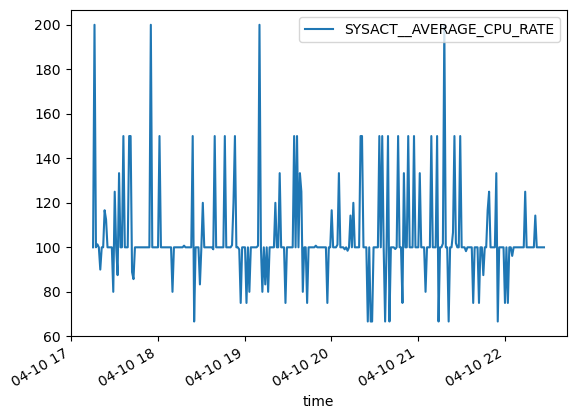

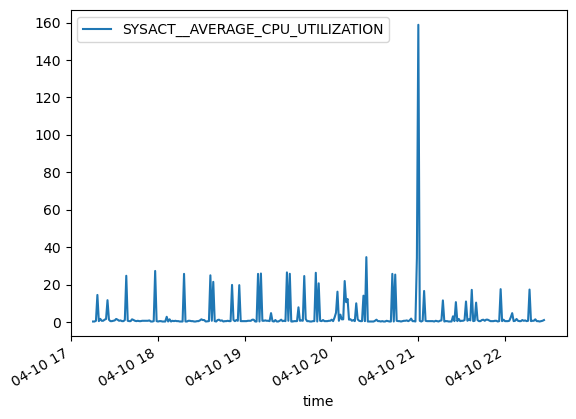

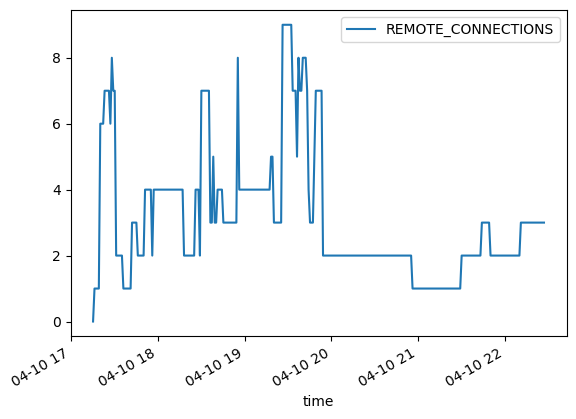

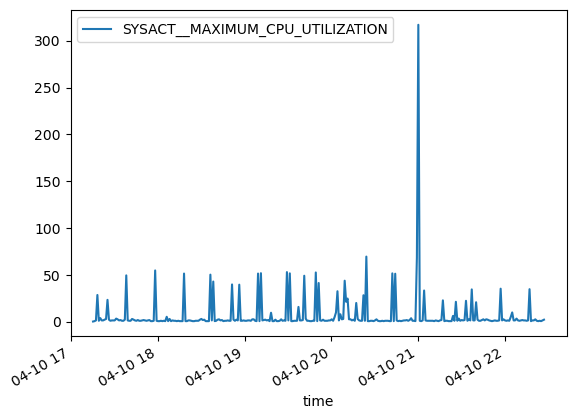

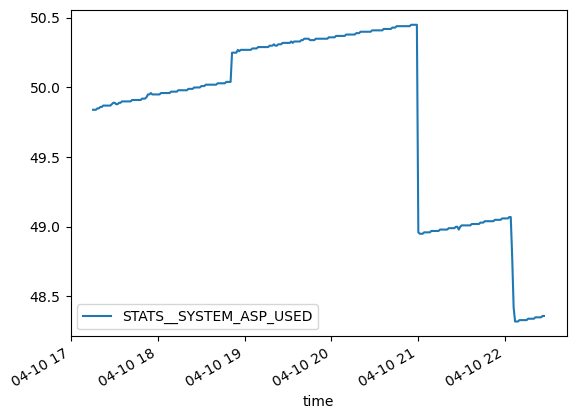

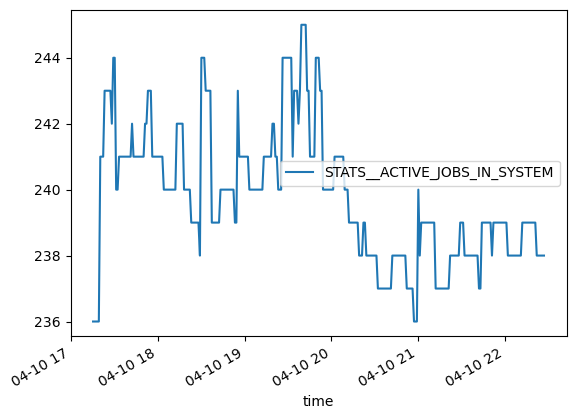

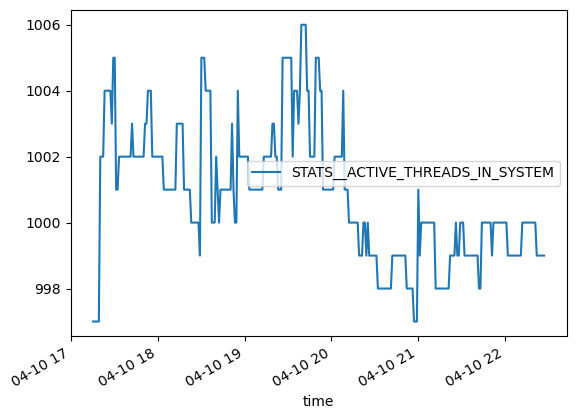

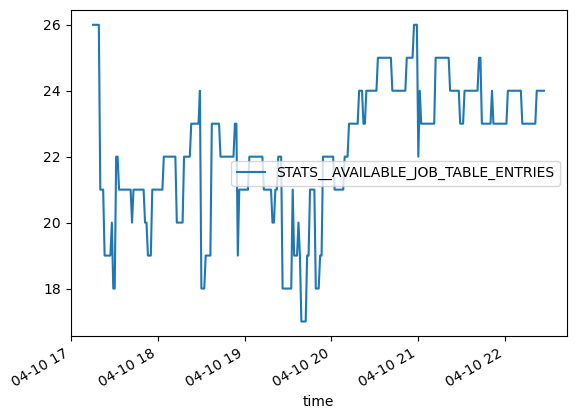

In [46]:
avg_cpu_rate_df.plot()
avg_cpu_util_df.plot()
remote_connections_df.plot()
max_cpu_util_df.plot()
system_asp_used_df.plot()
active_jobs_df.plot()
active_threads_df.plot()
avail_job_table_entries_df.plot()

## Experiment with Different Queries

Lightgbm (Light Gradient Boosting Machine) is a fast and efficient gradient boosting framework that uses a tree-based learning algorithm. It works by building decision trees in a sequential manner, with each new tree learning from the errors of the previous trees. The final model is an ensemble of these decision trees.

Lightgbm is particularly useful for time series analysis because it can handle large amounts of data and perform well even when the number of features is much larger than the number of samples. It can also handle missing values and categorical features, and has been shown to outperform other popular time series forecasting models like ARIMA and Prophet.


sysact df shape: (312, 8)
Train/Valid/Test sizes: (218, 7) (94, 7) (218,) (94,)


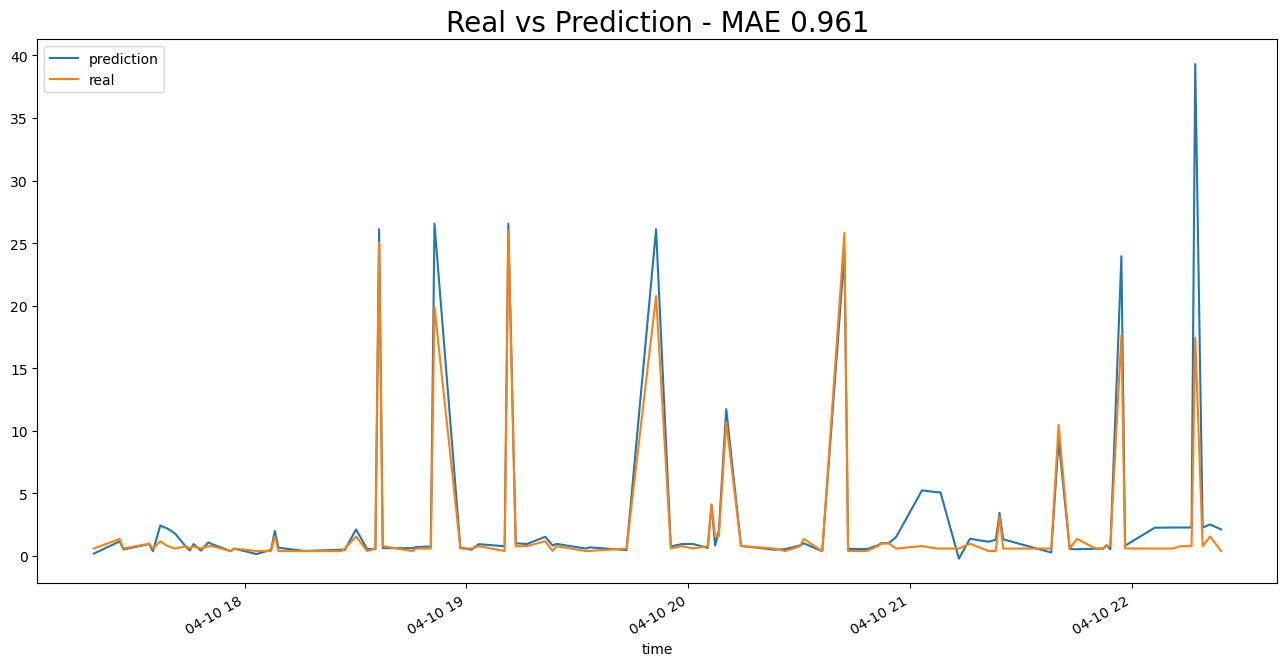

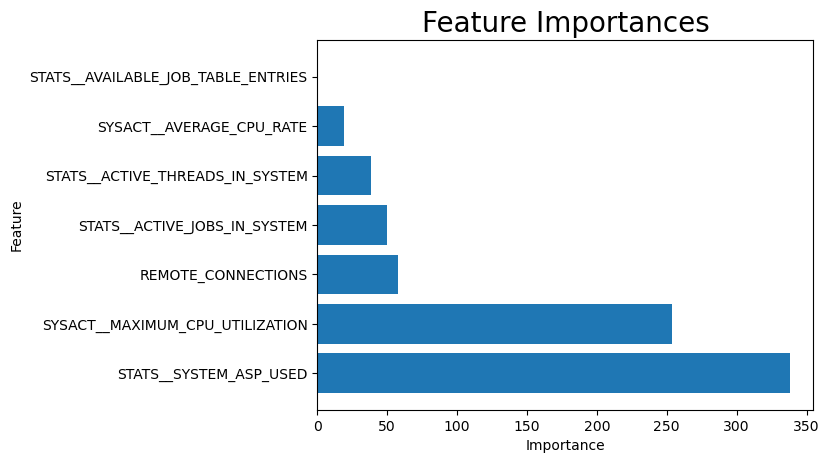

In [47]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


experiment = avg_cpu_util

sysact_df = pd.concat([v for k, v in client.get_cleaned_metrics().items() if k not in []], axis=1)
print("sysact df shape:", sysact_df.shape)

sysact_copy_df = sysact_df.copy()
X = sysact_copy_df.drop(experiment, inplace=False, axis=1)
y = sysact_df[experiment]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=123)

print('Train/Valid/Test sizes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#create, train and do inference of the model
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

#calculate MAE
mae = np.round(mean_absolute_error(y_test, predictions), 3)    

#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,8))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
pd.Series(predictions, index=y_test.index).plot(label='prediction')
y_test.plot(label='real')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


# Create a horizontal bar plot
plt.title('Feature Importances', fontsize=20)
plt.barh(y=df_importances['feature'], width=df_importances['importance'])

# Set the axis labels
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.show()





## Pull all Metrics from Prometheus Server

Below we grab all availbe metrics from the Prometheus server and store them in a dictionary. We can then use this dictionary to explore the data and create visualizations.

In [48]:
metrics_url = "http://localhost:9090/api/v1/label/__name__/values"
metrics_client = PrometheusQuery(metrics_url)
metrics_data = metrics_client.get_data()

hook = "__"
custom_metrics = []
old_metrics = ['UT33P23', 'UT51P41']
for metric in metrics_data['data']:
    if hook in metric and all(m not in metric for m in old_metrics):
        custom_metrics.append(metric)
        
print("len of custom metrics:", len(custom_metrics))

for metric in custom_metrics:
    metric_df = client.run_query(metric, step)

client.cleaned_metrics.keys()

    

len of custom metrics: 402


dict_keys(['SYSACT__AVERAGE_CPU_RATE', 'SYSACT__AVERAGE_CPU_UTILIZATION', 'REMOTE_CONNECTIONS', 'SYSACT__MAXIMUM_CPU_UTILIZATION', 'STATS__SYSTEM_ASP_USED', 'STATS__ACTIVE_JOBS_IN_SYSTEM', 'STATS__ACTIVE_THREADS_IN_SYSTEM', 'STATS__AVAILABLE_JOB_TABLE_ENTRIES', 'MEMPOOL__BASE__CURRENT_SIZE', 'MEMPOOL__BASE__CURRENT_THREADS', 'MEMPOOL__BASE__DEFINED_SIZE', 'MEMPOOL__BASE__MAXIMUM_ACTIVE_THREADS', 'MEMPOOL__BASE__RESERVED_SIZE', 'MEMPOOL__INTERACT__CURRENT_SIZE', 'MEMPOOL__INTERACT__CURRENT_THREADS', 'MEMPOOL__INTERACT__DEFINED_SIZE', 'MEMPOOL__INTERACT__MAXIMUM_ACTIVE_THREADS', 'MEMPOOL__INTERACT__RESERVED_SIZE', 'MEMPOOL__MACHINE__CURRENT_SIZE', 'MEMPOOL__MACHINE__CURRENT_THREADS', 'MEMPOOL__MACHINE__DEFINED_SIZE', 'MEMPOOL__MACHINE__MAXIMUM_ACTIVE_THREADS', 'MEMPOOL__MACHINE__RESERVED_SIZE', 'MEMPOOL__SHRPOOL10__CURRENT_SIZE', 'MEMPOOL__SHRPOOL10__CURRENT_THREADS', 'MEMPOOL__SHRPOOL10__DEFINED_SIZE', 'MEMPOOL__SHRPOOL10__MAXIMUM_ACTIVE_THREADS', 'MEMPOOL__SHRPOOL10__RESERVED_SIZE', 'M

In [49]:
# concat all the dataframes
master_df = pd.concat([v for k, v in client.get_cleaned_metrics().items() if k not in []], axis=1)
print("sysact df shape:", master_df.shape)

# drop columns with only one unique value
master_df = master_df.loc[:, master_df.nunique() != 1]
master_df.describe()

sysact df shape: (312, 403)


,SYSACT__AVERAGE_CPU_RATE,SYSACT__AVERAGE_CPU_UTILIZATION,REMOTE_CONNECTIONS,SYSACT__MAXIMUM_CPU_UTILIZATION,STATS__SYSTEM_ASP_USED,STATS__ACTIVE_JOBS_IN_SYSTEM,STATS__ACTIVE_THREADS_IN_SYSTEM,STATS__AVAILABLE_JOB_TABLE_ENTRIES,MEMPOOL__BASE__CURRENT_THREADS,MEMPOOL__BASE__RESERVED_SIZE,MEMPOOL__MACHINE__RESERVED_SIZE,STATS__ACTIVE_JOB_TABLE_ENTRIES,STATS__CURRENT_TEMPORARY_STORAGE,STATS__IN_USE_JOB_TABLE_ENTRIES,STATS__PERMANENT_JOB_STRUCTURES_AVAILABLE,STATS__TEMPORARY_JOB_STRUCTURES_AVAILABLE,STATS__TOTAL_CPU_TIME,STATS__TOTAL_JOBS_IN_SYSTEM
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,3.120000e+02,312.000000
mean,103.929135,3.466635,3.096154,6.922051,49.803910,239.772436,1000.801282,22.227564,852.782051,6.690321,674.066250,239.772436,18864.269231,6503.772436,22.227564,807.227564,1.387415e+14,6504.772436
std,19.958671,10.942813,1.935549,21.865347,0.649839,2.019871,2.026893,2.019871,2.008967,0.002384,0.020249,2.019871,901.559733,2.019871,2.019871,2.019871,9.167711e+10,2.019871
min,66.660000,0.380000,0.000000,0.380000,48.320000,236.000000,997.000000,17.000000,849.000000,6.690000,674.010000,236.000000,15817.000000,6500.000000,17.000000,802.000000,1.385972e+14,6501.000000
25%,100.000000,0.580000,2.000000,1.160000,49.050000,238.000000,999.000000,21.000000,851.000000,6.690000,674.057500,238.000000,18677.750000,6502.000000,21.000000,806.000000,1.386620e+14,6503.000000
50%,100.000000,0.770000,2.000000,1.550000,49.990000,240.000000,1001.000000,22.000000,853.000000,6.690000,674.060000,240.000000,19100.000000,6504.000000,22.000000,807.000000,1.387323e+14,6505.000000
75%,100.000000,1.160000,4.000000,2.330000,50.340000,241.000000,1002.000000,24.000000,854.000000,6.690000,674.070000,241.000000,19382.250000,6505.000000,24.000000,809.000000,1.388402e+14,6506.000000
max,200.000000,158.800000,9.000000,316.980000,50.450000,245.000000,1006.000000,26.000000,858.000000,6.710000,674.130000,245.000000,19743.000000,6509.000000,26.000000,811.000000,1.388963e+14,6510.000000


In [50]:
def run_lgb_experiment(data: pd.DataFrame, target: str) -> None:

    sysact_copy_df = data.copy()
    X = sysact_copy_df.drop(target, inplace=False, axis=1)
    y = data[target]

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state=123)

    print('Train/Valid/Test sizes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    #create, train and do inference of the model
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    

    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    pd.Series(predictions, index=y_test.index).plot(label='prediction')
    y_test.plot(label='real')

    # Add a legend to the plot
    plt.legend()

    # Show the plot
    plt.show()
    # Create a horizontal bar plot
    plt.title('Feature Importances', fontsize=20)
    plt.barh(y=df_importances['feature'], width=df_importances['importance'])

    # Set the axis labels
    plt.xlabel('Importance')
    plt.ylabel('Feature')

    # Show the plot
    plt.show()
    
    return model 

Train/Valid/Test sizes: (218, 17) (94, 17) (218,) (94,)


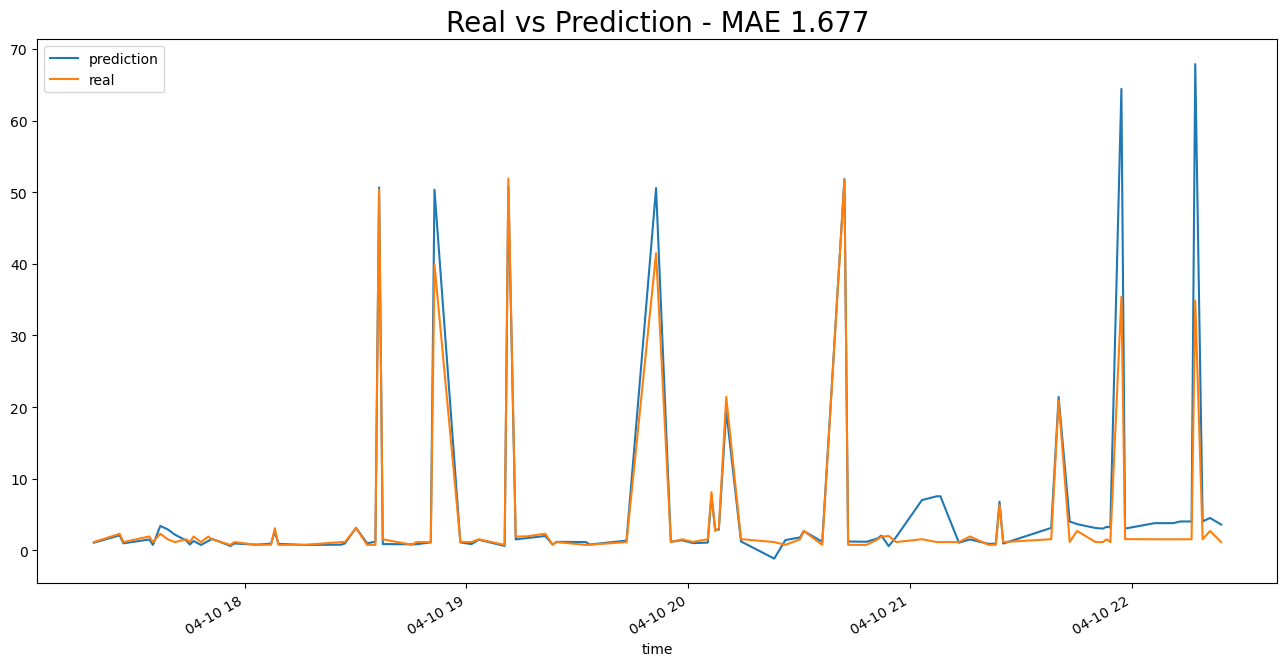

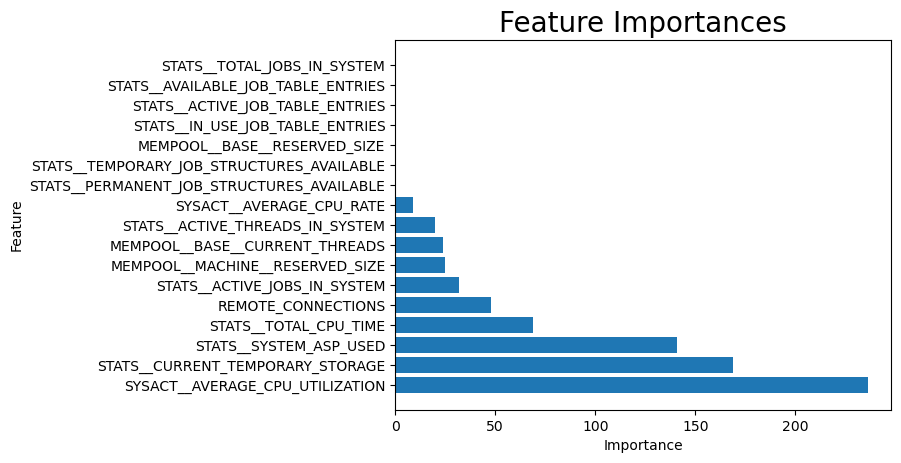

In [51]:
model = run_lgb_experiment(master_df, max_cpu_util)

In [52]:
df_importances = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

df_importances = df_importances.loc[(df_importances != 0).all(axis=1)]
df_importances

,feature,importance
1,SYSACT__AVERAGE_CPU_UTILIZATION,236
11,STATS__CURRENT_TEMPORARY_STORAGE,169
3,STATS__SYSTEM_ASP_USED,141
15,STATS__TOTAL_CPU_TIME,69
2,REMOTE_CONNECTIONS,48
4,STATS__ACTIVE_JOBS_IN_SYSTEM,32
9,MEMPOOL__MACHINE__RESERVED_SIZE,25
7,MEMPOOL__BASE__CURRENT_THREADS,24
5,STATS__ACTIVE_THREADS_IN_SYSTEM,20
0,SYSACT__AVERAGE_CPU_RATE,9


In [53]:
pruned_df = master_df.loc[:, df_importances['feature']]
pruned_df.head()

,SYSACT__AVERAGE_CPU_UTILIZATION,STATS__CURRENT_TEMPORARY_STORAGE,STATS__SYSTEM_ASP_USED,STATS__TOTAL_CPU_TIME,REMOTE_CONNECTIONS,STATS__ACTIVE_JOBS_IN_SYSTEM,MEMPOOL__MACHINE__RESERVED_SIZE,MEMPOOL__BASE__CURRENT_THREADS,STATS__ACTIVE_THREADS_IN_SYSTEM,SYSACT__AVERAGE_CPU_RATE
time,,,,,,,,,,
2023-04-10 17:15:10.628000021,0.38,18374.0,49.84,1.385972e+14,0.0,236.0,674.01,849.0,997.0,100.00
2023-04-10 17:16:10.584000111,0.38,18379.0,49.84,1.385980e+14,1.0,236.0,674.01,849.0,997.0,200.00
2023-04-10 17:17:10.539000034,0.77,18384.0,49.84,1.385987e+14,1.0,236.0,674.01,849.0,997.0,100.00
2023-04-10 17:18:10.494999886,14.56,18389.0,49.85,1.385995e+14,1.0,236.0,674.01,849.0,997.0,101.35
2023-04-10 17:19:10.450000048,0.58,18394.0,49.85,1.386002e+14,1.0,236.0,674.01,849.0,997.0,100.00


Train/Valid/Test sizes: (218, 9) (94, 9) (218,) (94,)


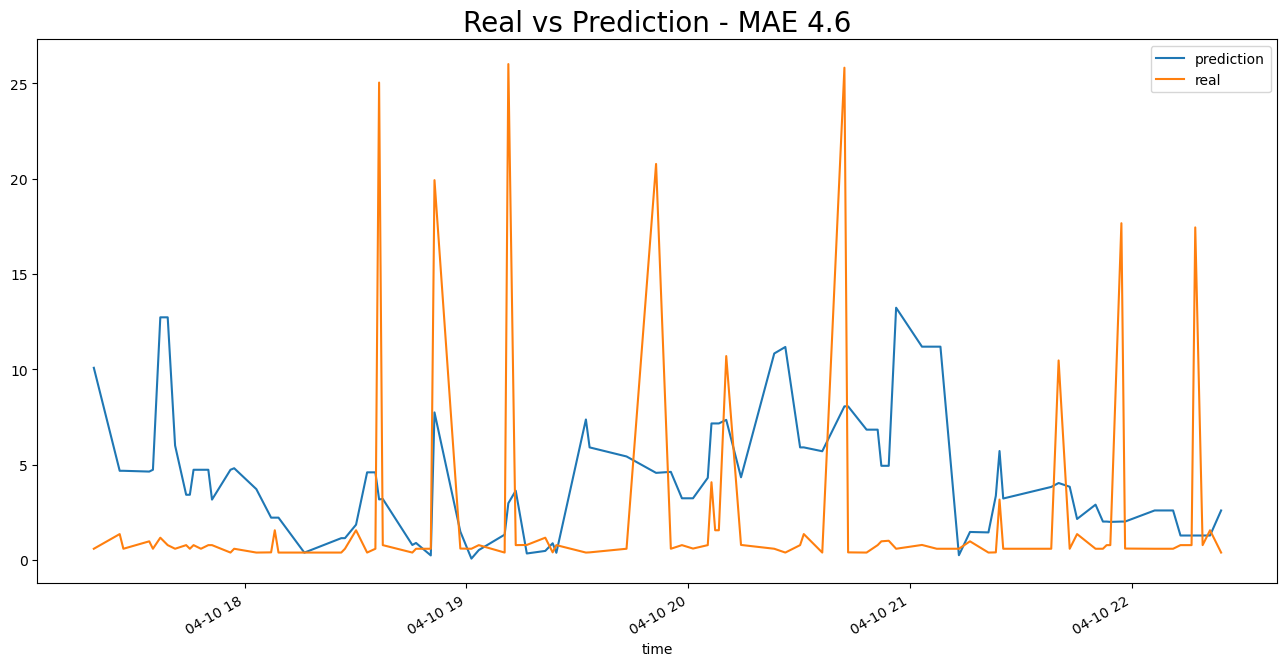

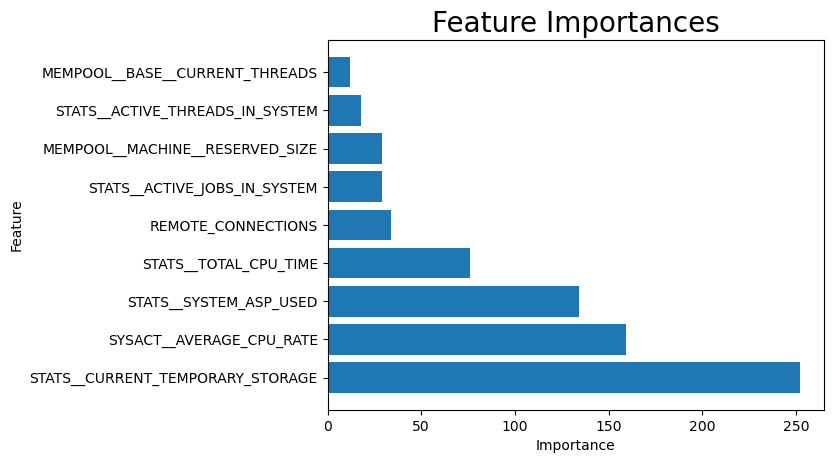

In [54]:
pruned_model = run_lgb_experiment(pruned_df, avg_cpu_util)

## Discussion

The MAE (Mean Absolute Error) score of LGBMRegressor can increase with more feature columns due to a phenomenon known as the curse of dimensionality. The curse of dimensionality occurs when the number of features or dimensions increases, and the data becomes sparser and more spread out. In this case, the model may struggle to find meaningful relationships between the features and the target variable, leading to a decrease in predictive performance.

Other potential reasons that the MAE score of LGBMRegressor can be higher with more feature columns include:

- Multicollinearity: If some of the features are highly correlated with each other, this can lead to multicollinearity, which can make it difficult for the model to distinguish the effects of individual features.

- Noise: Adding irrelevant or noisy features to the model can decrease its overall predictive performance, as the model will try to learn relationships that do not actually exist in the data.

- Overfitting: If the model has too many features relative to the number of training examples, it may be prone to overfitting, which occurs when the model fits the training data too closely and fails to generalize well to new, unseen data. This could be going on in the first models because they have a lot of features relative to the number of training examples.
